# Load datasets

In [66]:
import os
import cv2
import imghdr

# Function to load images from a directory
def load_images_from_directory(directory):
    images = []
    labels = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            if imghdr.what(filepath):  # Check if the file is an image
                image = cv2.imread(filepath)
                if image is not None:
                    images.append(image)
                    labels.append(os.path.basename(subdir))
    return images, labels

# Example usage
train_dir = '/kaggle/input/3-labels/dataset_3_labels_train_test/train'
test_dir = '/kaggle/input/3-labels/dataset_3_labels_train_test/test'

train_images, train_labels = load_images_from_directory(train_dir)
test_images, test_labels = load_images_from_directory(test_dir)

In [67]:
print(f"Đã tải lên {len(train_images)} ảnh vào biến train")
print(f"Đã tải lên  {len(test_images)} ảnh vào biến test")
# Get unique labels
unique_train_labels = set(train_labels)
unique_test_labels = set(test_labels)

# Print unique labels
print("Giá trị của train labels:", unique_train_labels)
print("Giá trị của test labels:", unique_test_labels)

Đã tải lên 839 ảnh vào biến train
Đã tải lên  92 ảnh vào biến test
Giá trị của train labels: {'Platanus', 'Sapindus saponaria', 'Michelia chapensis'}
Giá trị của test labels: {'Platanus', 'Sapindus saponaria', 'Michelia chapensis'}


# Feature Extraction

In [68]:
import cv2

def apply_clahe(image):
    if len(image.shape) == 3:  # Nếu là ảnh màu, chuyển đổi sang ảnh xám
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Tạo đối tượng CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    # Áp dụng CLAHE lên ảnh
    return clahe.apply(image)


In [69]:
import numpy as np
from scipy.stats import skew, kurtosis

def extract_intensity_features(image):
    mean = np.mean(image)
    variance = np.var(image)
    skewness = skew(image.flatten())
    kurt = kurtosis(image.flatten())
    entropy = -np.sum(np.multiply(image, np.log2(image + 1e-7)))
    energy = np.sum(np.square(image))
    return [mean, variance, skewness, kurt, entropy, energy]


In [70]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops

def extract_glcm_features(image):
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(image, [1], angles, levels=256, symmetric=True, normed=True)
    
    features = []
    feature_names = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    
    for angle_idx, angle in enumerate(angles):
        for feat_name in feature_names:
            feat_value = graycoprops(glcm, feat_name)[0, angle_idx]
            features.append(feat_value)
    
    return features


In [71]:
# Load images and extract features
features = []
for image in train_images:
    # Apply CLAHE
    clahe_image = apply_clahe(image)
    
    # Extract intensity features
    intensity_feats = extract_intensity_features(clahe_image)
    
    # Extract GLCM features
    glcm_feats = extract_glcm_features(clahe_image)
    
    # Combine features
    all_feats = np.concatenate([intensity_feats, glcm_feats])
    features.append(all_feats)

In [72]:
# Load images and extract features
features_test = []
for image in test_images:
    # Apply CLAHE
    clahe_image = apply_clahe(image)
    
    # Extract intensity features
    intensity_feats = extract_intensity_features(clahe_image)
    
    # Extract GLCM features
    glcm_feats = extract_glcm_features(clahe_image)
    
    # Combine features
    all_feats = np.concatenate([intensity_feats, glcm_feats])
    features_test.append(all_feats)

In [73]:
# Create a DataFrame from features and train_labels
feature_names = [
    'mean_intensity', 'variance_intensity', 'skewness_intensity', 
    'kurtosis_intensity', 'entropy_intensity', 'energy_intensity',
    'contrast_0', 'contrast_45', 'contrast_90', 'contrast_135',
    'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135',
    'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135',
    'energy_0', 'energy_45', 'energy_90', 'energy_135',
    'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135'
]

In [74]:
import pandas as pd
df = pd.DataFrame(features, columns=feature_names)
df['label'] = train_labels  # Add label column

In [75]:
import pandas as pd
df_test = pd.DataFrame(features_test, columns=feature_names)
df_test['label'] = test_labels  # Add label column

In [76]:
# Save DataFrame to CSV file
csv_filename = '/kaggle/working/features_train.csv'
df.to_csv(csv_filename, index=False)

In [77]:
# Save DataFrame to CSV file
csv_filename = '/kaggle/working/features_test.csv'
df_test.to_csv(csv_filename, index=False)

# Features Selection

In [78]:
import warnings

# Bỏ qua tất cả các cảnh báo
warnings.filterwarnings('ignore')

In [79]:
import pandas as pd
features_df = pd.read_csv('/kaggle/input/features-train/features_train.csv')

In [80]:
from sklearn.preprocessing import KBinsDiscretizer
# Loại bỏ cột 'label' khỏi tập đặc trưng
features = features_df.drop(columns=['label'])

# Chuyển đổi các giá trị đặc trưng thành dạng rời rạc
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
discrete_features = discretizer.fit_transform(features)

# Chuyển đổi ngược lại thành DataFrame để dễ xử lý
discrete_features_df = pd.DataFrame(discrete_features, columns=features.columns)

In [81]:
print(features['mean_intensity'].max())
print(features['mean_intensity'].min())

153.34787239583332
115.70363322953736


In [82]:
# Mã hóa ngược các nhãn để xác định các khoảng ban đầu
inverse_transformed = discretizer.inverse_transform(discrete_features)

# Chuyển đổi ngược lại thành DataFrame để dễ xử lý
inverse_transformed_df = pd.DataFrame(inverse_transformed, columns=features.columns)

# In ra các khoảng của các giá trị ban đầu
for col in features.columns:
    bins = discretizer.bin_edges_[features.columns.get_loc(col)]
    print(f"{col} bins: {bins}")

# Hiển thị một số hàng của dữ liệu ban đầu và dữ liệu đã được mã hóa ngược
print("Dữ liệu ban đầu:")
features.head()
print("\nDữ liệu đã được mã hóa ngược:")
inverse_transformed_df.head()

mean_intensity bins: [115.70363323 119.46805715 123.23248106 126.99690498 130.7613289
 134.52575281 138.29017673 142.05460065 145.81902456 149.58344848
 153.3478724 ]
variance_intensity bins: [1584.3900493  1977.39308145 2370.3961136  2763.39914574 3156.40217789
 3549.40521004 3942.40824219 4335.41127434 4728.41430649 5121.41733863
 5514.42037078]
skewness_intensity bins: [-1.22767214 -1.01599562 -0.8043191  -0.59264258 -0.38096606 -0.16928954
  0.04238698  0.2540635   0.46574002  0.67741654  0.88909306]
kurtosis_intensity bins: [-1.47179845 -1.19995219 -0.92810592 -0.65625965 -0.38441339 -0.11256712
  0.15927915  0.43112541  0.70297168  0.97481795  1.24666421]
entropy_intensity bins: [-2.38205097e+09 -2.21683947e+09 -2.05162798e+09 -1.88641648e+09
 -1.72120498e+09 -1.55599349e+09 -1.39078199e+09 -1.22557050e+09
 -1.06035900e+09 -8.95147506e+08 -7.29936010e+08]
energy_intensity bins: [8.12948390e+07 1.00496074e+08 1.19697308e+08 1.38898543e+08
 1.58099777e+08 1.77301012e+08 1.96502247e

,mean_intensity,variance_intensity,skewness_intensity,kurtosis_intensity,entropy_intensity,energy_intensity,contrast_0,contrast_45,contrast_90,contrast_135,...,homogeneity_90,homogeneity_135,energy_0,energy_45,energy_90,energy_135,correlation_0,correlation_45,correlation_90,correlation_135
0,132.643541,3352.903694,-0.063451,-1.064029,-9.777533e+08,110096690.9,660.389011,18.860435,0.060240,0.011374,...,261.967960,15.902335,0.093476,0.01076,0.907702,752.726418,21.850144,0.050625,0.010594,0.849490
1,132.643541,4138.909758,-0.063451,-1.064029,-1.803811e+09,206102863.9,660.389011,15.673155,0.097556,0.011374,...,707.883768,20.520141,0.093476,0.01076,0.907702,1209.189031,21.850144,0.083759,0.010594,0.849490
2,132.643541,4138.909758,-0.063451,-1.064029,-1.803811e+09,206102863.9,907.339965,22.047715,0.060240,0.011374,...,2045.631192,34.373557,0.055675,0.01076,0.796069,2122.114256,35.562259,0.050625,0.010594,0.741042
3,128.879117,4531.912790,0.148225,-1.064029,-1.803811e+09,206102863.9,1895.143782,28.422275,0.060240,0.011374,...,4275.210232,48.226973,0.055675,0.01076,0.516984,4404.427318,49.274374,0.050625,0.010594,0.524147
4,128.879117,4531.912790,-0.063451,-1.064029,-1.803811e+09,206102863.9,660.389011,15.673155,0.097556,0.011374,...,707.883768,20.520141,0.093476,0.01076,0.907702,1209.189031,21.850144,0.083759,0.010594,0.849490


In [83]:
discrete_features_df

,mean_intensity,variance_intensity,skewness_intensity,kurtosis_intensity,entropy_intensity,energy_intensity,contrast_0,contrast_45,contrast_90,contrast_135,...,homogeneity_90,homogeneity_135,energy_0,energy_45,energy_90,energy_135,correlation_0,correlation_45,correlation_90,correlation_135
0,4.0,4.0,5.0,1.0,8.0,1.0,2.0,4.0,0.0,0.0,...,0.0,2.0,1.0,0.0,8.0,1.0,3.0,0.0,0.0,7.0
1,4.0,6.0,5.0,1.0,3.0,6.0,2.0,3.0,1.0,0.0,...,1.0,3.0,1.0,0.0,8.0,2.0,3.0,1.0,0.0,7.0
2,4.0,6.0,5.0,1.0,3.0,6.0,3.0,5.0,0.0,0.0,...,4.0,6.0,0.0,0.0,6.0,4.0,6.0,0.0,0.0,5.0
3,3.0,7.0,6.0,1.0,3.0,6.0,7.0,7.0,0.0,0.0,...,9.0,9.0,0.0,0.0,1.0,9.0,9.0,0.0,0.0,1.0
4,3.0,7.0,5.0,1.0,3.0,6.0,2.0,3.0,1.0,0.0,...,1.0,3.0,1.0,0.0,8.0,2.0,3.0,1.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,3.0,7.0,6.0,1.0,3.0,6.0,3.0,4.0,2.0,0.0,...,2.0,3.0,2.0,0.0,7.0,3.0,4.0,1.0,0.0,6.0
835,3.0,4.0,6.0,2.0,3.0,6.0,1.0,3.0,2.0,0.0,...,2.0,3.0,1.0,0.0,7.0,2.0,4.0,1.0,0.0,7.0
836,6.0,5.0,5.0,1.0,2.0,6.0,1.0,2.0,6.0,2.0,...,1.0,2.0,6.0,2.0,8.0,1.0,2.0,6.0,2.0,8.0
837,4.0,7.0,5.0,1.0,3.0,6.0,6.0,6.0,2.0,0.0,...,3.0,4.0,2.0,0.0,6.0,5.0,5.0,2.0,0.0,4.0


In [84]:
# Save DataFrame to CSV file
csv_filename = '/kaggle/working/discrete_features_df.csv'
discrete_features_df.to_csv(csv_filename, index=False)

In [85]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

# Load the discrete features DataFrame
discrete_features_df = pd.read_csv('/kaggle/working/discrete_features_df.csv')

# Tạo danh sách giao dịch có gắn nhãn đặc trưng
transactions_list = []
for index, row in discrete_features_df.iterrows():
    transaction = [f'{col}_{int(val)}' for col, val in row.items()]
    transactions_list.append(transaction)

# Sử dụng TransactionEncoder để chuyển đổi danh sách giao dịch thành DataFrame nhị phân
te = TransactionEncoder()
te_ary = te.fit(transactions_list).transform(transactions_list)
binary_features_df = pd.DataFrame(te_ary, columns=te.columns_)

# Hiển thị DataFrame sau khi chuyển đổi
binary_features_df.head()

,contrast_0_0,contrast_0_1,contrast_0_2,contrast_0_3,contrast_0_4,contrast_0_5,contrast_0_6,contrast_0_7,contrast_0_8,contrast_0_9,...,variance_intensity_0,variance_intensity_1,variance_intensity_2,variance_intensity_3,variance_intensity_4,variance_intensity_5,variance_intensity_6,variance_intensity_7,variance_intensity_8,variance_intensity_9
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [86]:
# Save DataFrame to CSV file
csv_filename = '/kaggle/working/binary_features_df_with_name.csv'
binary_features_df.to_csv(csv_filename, index=False)

In [87]:
from mlxtend.frequent_patterns import apriori, association_rules

# Sử dụng thuật toán Apriori để tìm các tập hợp thường xuyên
frequent_itemsets = apriori(binary_features_df, min_support=0.6, use_colnames=True)

# Tạo các luật kết hợp từ các tập hợp thường xuyên
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

In [88]:
frequent_itemsets

,support,itemsets
0,0.840286,(contrast_135_0)
1,0.873659,(correlation_90_0)
2,0.827175,(energy_45_0)
3,0.930870,(energy_intensity_6)
4,0.741359,(entropy_intensity_3)
...,...,...
58,0.641240,"(homogeneity_0_0, contrast_135_0, energy_45_0,..."
59,0.646007,"(homogeneity_0_0, contrast_135_0, entropy_inte..."
60,0.641240,"(homogeneity_0_0, contrast_135_0, energy_45_0,..."
61,0.646007,"(homogeneity_0_0, energy_45_0, entropy_intensi..."


In [89]:
# Save DataFrame to CSV file
csv_filename = '/kaggle/working/frequent_itemsets.csv'
frequent_itemsets.to_csv(csv_filename, index=False)

In [90]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(contrast_135_0),(correlation_90_0),0.840286,0.873659,0.840286,1.000000,1.144611,0.106162,inf,0.791045
1,(correlation_90_0),(contrast_135_0),0.873659,0.840286,0.840286,0.961801,1.144611,0.106162,4.181083,1.000000
2,(contrast_135_0),(energy_45_0),0.840286,0.827175,0.822408,0.978723,1.183212,0.127344,8.122765,0.969500
3,(energy_45_0),(contrast_135_0),0.827175,0.840286,0.822408,0.994236,1.183212,0.127344,27.710369,0.895952
4,(energy_intensity_6),(contrast_135_0),0.930870,0.840286,0.798570,0.857875,1.020932,0.016373,1.123753,0.296577


In [91]:
# Save DataFrame to CSV file
csv_filename = '/kaggle/working/rules.csv'
rules.to_csv(csv_filename, index=False)

In [92]:
# Đánh giá các luật dựa trên các chỉ số
def evaluate_rules(rules, min_support, min_confidence, min_lift):
    return rules[(rules['support'] >= min_support) & 
                 (rules['confidence'] >= min_confidence) & 
                 (rules['lift'] >= min_lift)]

In [93]:
min_support = 0.6
min_confidence = 0.7
min_lift = 1.0

In [94]:
# Lọc và đánh giá các luật
evaluated_rules = evaluate_rules(rules, min_support, min_confidence, min_lift)

In [95]:
# Hiển thị các luật sau khi đánh giá
print(evaluated_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

            antecedents         consequents   support  confidence      lift
0      (contrast_135_0)  (correlation_90_0)  0.840286    1.000000  1.144611
1    (correlation_90_0)    (contrast_135_0)  0.840286    0.961801  1.144611
2      (contrast_135_0)       (energy_45_0)  0.822408    0.978723  1.183212
3         (energy_45_0)    (contrast_135_0)  0.822408    0.994236  1.183212
4  (energy_intensity_6)    (contrast_135_0)  0.798570    0.857875  1.020932


In [96]:
# Xác định các thuộc tính quan trọng từ các luật kết hợp
important_features = pd.Series(evaluated_rules['antecedents'].tolist() + evaluated_rules['consequents'].tolist()).value_counts()
print("Các thuộc tính quan trọng:")
print(important_features)

Các thuộc tính quan trọng:
(contrast_135_0)                                                                                62
(correlation_90_0)                                                                              62
(energy_45_0)                                                                                   62
(entropy_intensity_3)                                                                           62
(homogeneity_0_0)                                                                               62
                                                                                                ..
(homogeneity_0_0, contrast_135_0, energy_45_0, correlation_90_0, energy_intensity_6)             2
(homogeneity_0_0, energy_45_0, entropy_intensity_3, correlation_90_0, energy_intensity_6)        2
(homogeneity_0_0, contrast_135_0, entropy_intensity_3, correlation_90_0, energy_intensity_6)     2
(contrast_135_0, energy_45_0, entropy_intensity_3, correlation_90_0, energy_intens

In [97]:
important_features_df = important_features.reset_index()
important_features_df.columns = ['attribute', 'count']

In [98]:
# Hiển thị DataFrame
print(important_features_df)

                                            attribute  count
0                                    (contrast_135_0)     62
1                                  (correlation_90_0)     62
2                                       (energy_45_0)     62
3                               (entropy_intensity_3)     62
4                                   (homogeneity_0_0)     62
..                                                ...    ...
57  (homogeneity_0_0, contrast_135_0, energy_45_0,...      2
58  (homogeneity_0_0, energy_45_0, entropy_intensi...      2
59  (homogeneity_0_0, contrast_135_0, entropy_inte...      2
60  (contrast_135_0, energy_45_0, entropy_intensit...      2
61  (homogeneity_0_0, contrast_135_0, energy_45_0,...      1

[62 rows x 2 columns]


In [99]:
# Lấy các thuộc tính quan trọng từ DataFrame
important_features = important_features_df['attribute'].tolist()

# Chuyển đổi frozenset thành chuỗi nếu cần và lấy tên các thuộc tính gốc
def extract_feature_names(frozenset_str):
    if 'frozenset' in frozenset_str:
        frozenset_str = frozenset_str.replace('frozenset({', '').replace('})', '').replace("'", "")
    # Remove parentheses and split by comma
    return [feat.split('_')[0] for feat in frozenset_str.replace('(', '').replace(')', '').split(', ')]

important_original_features = set()
for item in important_features:
    if isinstance(item, str) and 'frozenset' in item:
        item = eval(item)
    if isinstance(item, frozenset):
        for sub_item in item:
            important_original_features.update(extract_feature_names(sub_item))
    else:
        important_original_features.update(extract_feature_names(item))

In [100]:
important_original_features = list(important_original_features)

print("Các thuộc tính gốc quan trọng:")
print(important_original_features)

Các thuộc tính gốc quan trọng:
['energy', 'contrast', 'correlation', 'homogeneity', 'entropy']


# Huấn luyện mô hình dùng API

In [101]:
import warnings

# Bỏ qua tất cả các cảnh báo
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Bỏ qua các cảnh báo từ các thư viện cụ thể như Pandas và scikit-learn
warnings.filterwarnings("ignore", category=DeprecationWarning, module='pandas')
warnings.filterwarnings("ignore", category=DeprecationWarning, module='sklearn')

In [102]:
# Tải tệp CSV
features_train_file_path = '/kaggle/working/features_train.csv'
features_test_file_path = '/kaggle/working/features_test.csv'
features_train_df = pd.read_csv(features_train_file_path)
features_test_df = pd.read_csv(features_test_file_path)

In [103]:
important_features = ['entropy_intensity', 'correlation_90', 'contrast_135', 'homogeneity_0', 'energy_45', 'energy_intensity', 'variance_intensity' ]

In [104]:
print(features_train_df.columns)
print(features_test_df.columns)

Index(['mean_intensity', 'variance_intensity', 'skewness_intensity',
       'kurtosis_intensity', 'entropy_intensity', 'energy_intensity',
       'contrast_0', 'contrast_45', 'contrast_90', 'contrast_135',
       'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90',
       'dissimilarity_135', 'homogeneity_0', 'homogeneity_45',
       'homogeneity_90', 'homogeneity_135', 'energy_0', 'energy_45',
       'energy_90', 'energy_135', 'correlation_0', 'correlation_45',
       'correlation_90', 'correlation_135', 'label'],
      dtype='object')
Index(['mean_intensity', 'variance_intensity', 'skewness_intensity',
       'kurtosis_intensity', 'entropy_intensity', 'energy_intensity',
       'contrast_0', 'contrast_45', 'contrast_90', 'contrast_135',
       'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90',
       'dissimilarity_135', 'homogeneity_0', 'homogeneity_45',
       'homogeneity_90', 'homogeneity_135', 'energy_0', 'energy_45',
       'energy_90', 'energy_135', 'correlation_

In [105]:
# Tạo tập dữ liệu chỉ với các thuộc tính quan trọng
X_train = features_train_df[important_features]
y_train = features_train_df['label'] 
X_test = features_test_df[important_features]
y_test = features_test_df['label'] 

In [106]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [107]:
# Mã hóa nhãn
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
# Khởi tạo mô hình RandomForest
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [109]:
# Huấn luyện mô hình
model.fit(X_train_scaled, y_train_encoded)
# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test_scaled)

In [110]:
# Đánh giá mô hình
accuracy = accuracy_score(y_test_encoded, y_pred)
report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.6956521739130435
Classification Report:
                    precision    recall  f1-score   support

Michelia chapensis       0.69      0.83      0.75        35
          Platanus       0.62      0.57      0.59        28
Sapindus saponaria       0.79      0.66      0.72        29

          accuracy                           0.70        92
         macro avg       0.70      0.69      0.69        92
      weighted avg       0.70      0.70      0.69        92



# Hyper parameter Randomforest

In [111]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np

# Khởi tạo mô hình RandomForest
model = RandomForestClassifier(random_state=42)

In [112]:
# Định nghĩa các siêu tham số cần thử nghiệm
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [113]:
# Sử dụng GridSearchCV với k-fold cross-validation để tìm siêu tham số tối ưu
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train_encoded)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END 

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [114]:
# In ra các siêu tham số tốt nhất
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


In [115]:
# Đánh giá mô hình tốt nhất trên tập kiểm tra
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

In [116]:
# Đánh giá mô hình
accuracy = accuracy_score(y_test_encoded, y_pred)
report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.717391304347826
Classification Report:
                    precision    recall  f1-score   support

Michelia chapensis       0.69      0.83      0.75        35
          Platanus       0.67      0.57      0.62        28
Sapindus saponaria       0.81      0.72      0.76        29

          accuracy                           0.72        92
         macro avg       0.72      0.71      0.71        92
      weighted avg       0.72      0.72      0.71        92



In [117]:
# Tạo tập dữ liệu chỉ với các thuộc tính quan trọng
X_train1 = features_train_df.drop('label', axis=1)
y_train1 = features_train_df['label'] 
X_test1 = features_test_df.drop('label', axis=1)
y_test1 = features_test_df['label'] 

In [118]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled1 = scaler.fit_transform(X_train1)
X_test_scaled1 = scaler.transform(X_test1)

In [119]:
# Mã hóa nhãn
label_encoder = LabelEncoder()
y_train_encoded1 = label_encoder.fit_transform(y_train1)
y_test_encoded1 = label_encoder.transform(y_test1)

In [120]:
# Huấn luyện mô hình
model.fit(X_train_scaled1, y_train_encoded1)
# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test_scaled1)

In [121]:
# Đánh giá mô hình
accuracy = accuracy_score(y_test_encoded1, y_pred)
report = classification_report(y_test_encoded1, y_pred, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.8152173913043478
Classification Report:
                    precision    recall  f1-score   support

Michelia chapensis       0.81      0.97      0.88        35
          Platanus       0.83      0.71      0.77        28
Sapindus saponaria       0.81      0.72      0.76        29

          accuracy                           0.82        92
         macro avg       0.82      0.80      0.81        92
      weighted avg       0.82      0.82      0.81        92



In [122]:
feature_importances = model.feature_importances_

# Tạo DataFrame để hiển thị các đặc trưng quan trọng
features_importance_df = pd.DataFrame({
    'feature': X_train1.columns,
    'importance': feature_importances
})

# Sắp xếp các đặc trưng theo mức độ quan trọng
features_importance_df = features_importance_df.sort_values(by='importance', ascending=False)

# In ra các đặc trưng quan trọng

In [123]:
print("Các đặc trưng quan trọng mà mô hình đã học:")
print(features_importance_df)

Các đặc trưng quan trọng mà mô hình đã học:
               feature  importance
5     energy_intensity    0.129940
2   skewness_intensity    0.072628
3   kurtosis_intensity    0.066929
20           energy_90    0.061122
4    entropy_intensity    0.051112
1   variance_intensity    0.046464
8          contrast_90    0.040684
16      homogeneity_90    0.040252
23      correlation_45    0.039523
0       mean_intensity    0.038170
13   dissimilarity_135    0.034076
18            energy_0    0.033256
10     dissimilarity_0    0.029245
17     homogeneity_135    0.027120
25     correlation_135    0.026932
22       correlation_0    0.026673
11    dissimilarity_45    0.025117
9         contrast_135    0.025046
7          contrast_45    0.024617
21          energy_135    0.023824
19           energy_45    0.023708
24      correlation_90    0.023616
6           contrast_0    0.023288
15      homogeneity_45    0.023175
14       homogeneity_0    0.022116
12    dissimilarity_90    0.021365


# Vẽ cây quyết định

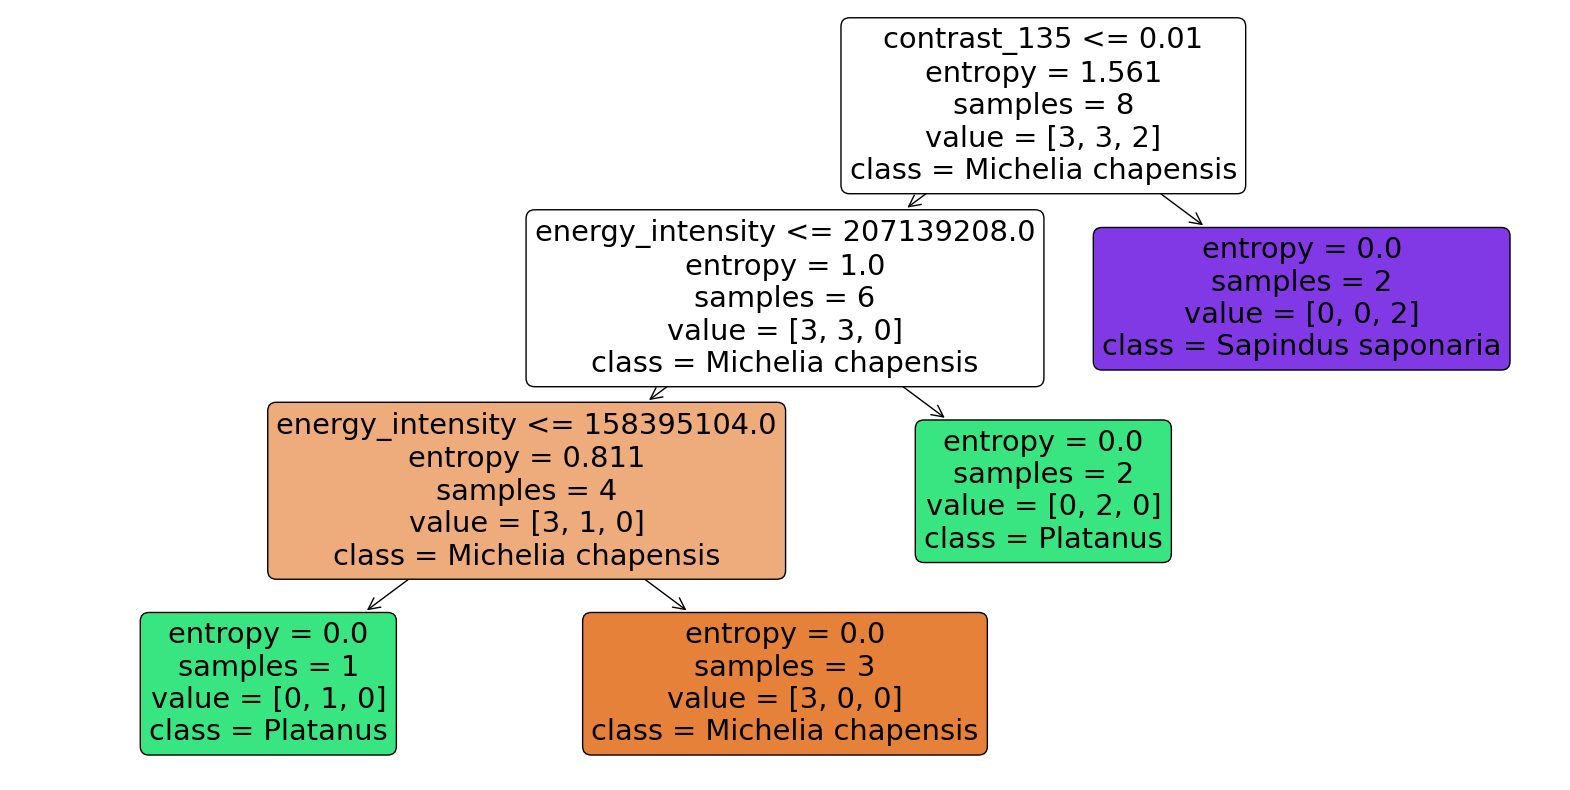

In [124]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/kaggle/input/decisiontree-dataset/data.csv')

# Prepare the data
X = data.drop(columns=['label'])
y = data['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Decision Tree classifier with entropy
clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
clf.fit(X_train, y_train)

# Plot the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=clf.classes_, rounded=True)
plt.show()


In [125]:
X_train

,entropy_intensity,correlation_90,contrast_135,homogeneity_0,energy_45,energy_intensity,variance_intensity
5,-1858249058,0.007258,0.008753,0.007288,0.008116,208491180,3971.528263
0,-1773360147,0.006440,0.007364,0.006160,0.007373,205787233,4390.147602
7,-1608351334,0.007867,0.010490,0.007888,0.008790,207553367,3701.158195
2,-1806387965,0.007220,0.008437,0.007318,0.008597,203778135,3873.767578
9,-1835403851,0.012967,0.015729,0.013177,0.015953,206580649,3088.662555
4,-1012158631,0.007908,0.008533,0.007972,0.009650,115608142,3227.556059
3,-1830705093,0.007921,0.009745,0.008152,0.009094,201182064,3739.327344
6,-1854626577,0.005673,0.007087,0.005453,0.005887,209093389,4324.142967


[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time